# 배터리 B0006 잔여 수명 예측 (PyTorch LSTM)

이 노트북은 NASA에서 공개한 B0006 배터리 데이터를 활용하여 LSTM 기반으로 잔여 수명(RUL)을 예측하는 과정을 정리합니다.

- 데이터 구조 탐색
- 시계열 전처리 및 정규화
- PyTorch LSTM 학습 및 평가


In [1]:
# 기본 라이브러리 및 PyTorch 관련 모듈 불러오기
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

In [2]:
# 재현성을 위한 시드 고정
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# 메타데이터를 불러와 특정 배터리를 선택
DATA_ROOT = Path("cleaned_dataset")
META_PATH = DATA_ROOT / "metadata.csv"

meta = pd.read_csv(META_PATH)

battery_id = "B0006"

# 선택한 배터리 id에 해당하는 discharge type 데이터 필터링 및 정렬
battery_meta = (
    meta[(meta["type"] == "discharge") & (meta["battery_id"] == battery_id)]
    .sort_values("start_time")
    .reset_index(drop=True)
)

# Capacity 열을 숫자형으로 변환하고 사이클 인덱스 및 RUL 열 추가
battery_meta["Capacity"] = pd.to_numeric(battery_meta["Capacity"], errors="coerce")
battery_meta["cycle_index"] = np.arange(len(battery_meta))
battery_meta["rul_cycle"] = len(battery_meta) - battery_meta["cycle_index"] - 1

display(battery_meta.head())
print(f"사이클 수: {len(battery_meta)}")

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct,cycle_index,rul_cycle
0,discharge,[2.0080e+03 4.0000e+00 1.9000e+01 1.3000e+01 1...,24,B0006,53,4558,04558.csv,1.924246,NaN,NaN,0,167
1,discharge,[2.0080e+03 4.0000e+00 2.0000e+00 1.5000e+01 2...,24,B0006,1,4506,04506.csv,2.035338,NaN,NaN,1,166
2,discharge,[2.0080e+03 4.0000e+00 2.0000e+00 1.9000e+01 4...,24,B0006,3,4508,04508.csv,2.025140,NaN,NaN,2,165
3,discharge,[2.0080e+03 4.0000e+00 2.3000e+01 1.0000e+00 1...,24,B0006,93,4598,04598.csv,1.855277,NaN,NaN,3,164
4,discharge,[2.0080e+03 4.0000e+00 2.3000e+01 2.1000e+01 2...,24,B0006,109,4614,04614.csv,1.797102,NaN,NaN,4,163


사이클 수: 168


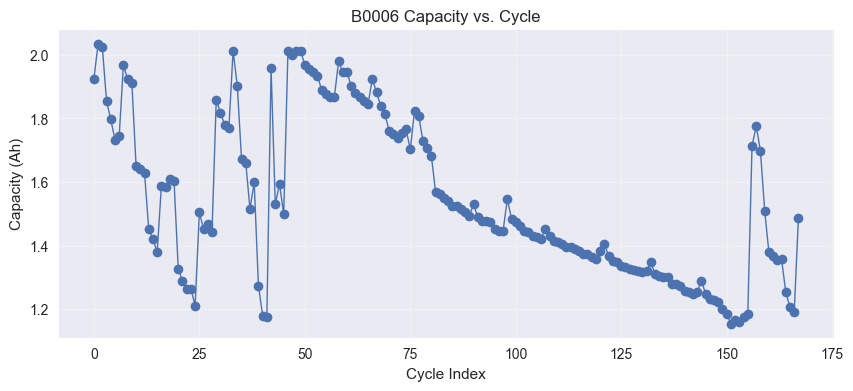

In [4]:
# 용량 감소 추이를 시각화하여 노화 패턴 확인
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(battery_meta["cycle_index"], battery_meta["Capacity"], marker="o", linewidth=1)
ax.set_xlabel("Cycle Index")
ax.set_ylabel("Capacity (Ah)")
ax.set_title(f"{battery_id} Capacity vs. Cycle")
ax.grid(True, alpha=0.3)
plt.show()

In [5]:
# 각 방전 사이클을 균일한 길이로 보간하는 함수 정의
SEQ_LEN = 120
FEATURE_COLS = [
    "Voltage_measured",
    "Current_measured",
    "Temperature_measured",
    "Current_load",
    "Voltage_load",
]

def load_cycle_sequence(filename: str, seq_len: int = SEQ_LEN) -> np.ndarray:
    """
        원본 csv마다 측정 시간이 다르기 때문에 SEQ_LEN 길이로 리샘플링
        -> 고정 길이 텐서로 맞춰주기 위함
    """
    path = DATA_ROOT / "data" / filename
    df = pd.read_csv(path).sort_values("Time")
    time = df["Time"].values
    new_time = np.linspace(time.min(), time.max(), seq_len)
    interpolated = []
    for col in FEATURE_COLS:
        interpolated.append(np.interp(new_time, time, df[col].values))
    return np.stack(interpolated, axis=1)

In [6]:
# 선택한 배터리의 모든 방전 사이클을 시퀀스로 변환
sequences = np.stack(
    [load_cycle_sequence(fname) for fname in battery_meta["filename"]],
    axis=0,
)
targets = battery_meta["rul_cycle"].astype(np.float32).to_numpy()
capacities = battery_meta["Capacity"].astype(np.float32).to_numpy()

print("시퀀스 형태:", sequences.shape)
print("RUL 범위:", targets.min(), targets.max())

시퀀스 형태: (168, 120, 5)
RUL 범위: 0.0 167.0


In [8]:
# 시퀀스를 학습/검증 세트로 분할하고 정규화 수행
# 데이터를 N개의 구간으로 나누어 각 구간에서 8:2 비율로 학습/검증 데이터 추출
N_SPLITS = 5
train_ratio = 0.8
total_cycles = len(sequences)
split_size = total_cycles // N_SPLITS

train_indices = []
val_indices = []

for i in range(N_SPLITS):
    start_idx = i * split_size
    # 마지막 구간은 남은 모든 데이터를 포함
    if i < N_SPLITS - 1:
        end_idx = (i + 1) * split_size
    else:
        end_idx = total_cycles
    
    segment_indices = np.arange(start_idx, end_idx)
    n_train = int(len(segment_indices) * train_ratio)
    
    train_indices.extend(segment_indices[:n_train])
    val_indices.extend(segment_indices[n_train:])
    
train_meta = battery_meta.iloc[train_indices].copy()
val_meta = battery_meta.iloc[val_indices].copy()

train_X = sequences[train_indices]
val_X = sequences[val_indices]
train_y = targets[train_indices]
val_y = targets[val_indices]

flat_train = train_X.reshape(-1, len(FEATURE_COLS))
mean = flat_train.mean(axis=0)
std = flat_train.std(axis=0) + 1e-6

train_X_norm = ((train_X - mean) / std).astype(np.float32)
val_X_norm = ((val_X - mean) / std).astype(np.float32)

normalizer = {"mean": mean, "std": std, "features": FEATURE_COLS}

print("정규화 평균:", mean)
print("정규화 표준편차:", std)

print("정규화된 학습 시퀀스 형태:", train_X_norm.shape)
print("정규화된 검증 시퀀스 형태:", val_X_norm.shape)

정규화 평균: [ 3.46584995 -1.77401389 32.81242613  1.0762752   2.25804597]
정규화 표준편차: [0.25274077 0.64472059 4.09219962 1.53759949 0.85445184]
정규화된 학습 시퀀스 형태: (132, 120, 5)
정규화된 검증 시퀀스 형태: (36, 120, 5)


In [9]:
# PyTorch Dataset과 DataLoader 정의
class CycleDataset(Dataset):
    def __init__(self, sequences: np.ndarray, targets: np.ndarray):
        self.x = torch.from_numpy(sequences)
        self.y = torch.from_numpy(targets)

    def __len__(self) -> int:
        return len(self.x)

    def __getitem__(self, idx: int):
        return self.x[idx], self.y[idx]

train_dataset = CycleDataset(train_X_norm, train_y.astype(np.float32))
val_dataset = CycleDataset(val_X_norm, val_y.astype(np.float32))

BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

len(train_dataset), len(val_dataset)


(132, 36)

In [10]:
# LSTM 회귀 모델 정의
class LSTMRegressor(nn.Module):
    def __init__(self, input_size: int, hidden_size: int = 64, num_layers: int = 2, dropout: float = 0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output, (hn, _) = self.lstm(x)
        last_hidden = hn[-1]
        prediction = self.fc(last_hidden)
        return prediction.squeeze(-1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMRegressor(input_size=len(FEATURE_COLS)).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 25

model

LSTMRegressor(
  (lstm): LSTM(5, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [11]:
# LSTM 모델 학습 루프
history = {"train_loss": [], "val_loss": []}
best_val = float("inf")
best_state = None

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)

    train_loss /= len(train_dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)

    val_loss /= len(val_dataset)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    if val_loss < best_val:
        best_val = val_loss
        best_state = model.state_dict()

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

if best_state is not None:
    model.load_state_dict(best_state)
    print(f"가장 낮은 검증 손실: {best_val:.4f}")


Epoch 01 | Train Loss: 9909.2201 | Val Loss: 7113.9915
Epoch 05 | Train Loss: 8914.2352 | Val Loss: 6291.2660
Epoch 10 | Train Loss: 8298.5662 | Val Loss: 5840.5837
Epoch 15 | Train Loss: 7808.4877 | Val Loss: 5471.7268
Epoch 20 | Train Loss: 7376.3287 | Val Loss: 5146.2385
Epoch 25 | Train Loss: 6982.9218 | Val Loss: 4857.0413
가장 낮은 검증 손실: 4857.0413


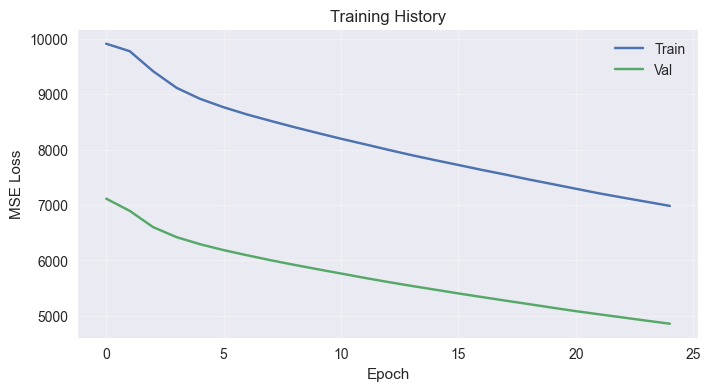

In [12]:
# 학습 및 검증 손실 곡선 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(history["train_loss"], label="Train")
ax.plot(history["val_loss"], label="Val")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE Loss")
ax.set_title("Training History")
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()


In [13]:
# 검증 세트에 대한 예측 및 지표 계산
model.eval()

def predict_dataset(loader: DataLoader):
    preds = []
    targets = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            preds_batch = model(xb).cpu().numpy()
            preds.append(preds_batch)
            targets.append(yb.numpy())
    return np.concatenate(preds), np.concatenate(targets)

val_preds, val_targets = predict_dataset(val_loader)

val_mae = np.mean(np.abs(val_preds - val_targets))
val_rmse = np.sqrt(np.mean((val_preds - val_targets) ** 2))

print(f"검증 MAE: {val_mae:.3f} 사이클")
print(f"검증 RMSE: {val_rmse:.3f} 사이클")


검증 MAE: 57.411 사이클
검증 RMSE: 69.692 사이클


In [14]:
# 예측 결과를 메타데이터와 결합하여 확인
val_results = val_meta.copy()
val_results = val_results.assign(
    pred_rul=val_preds,
    true_rul=val_targets,
    error=val_preds - val_targets,
)

val_results.loc[:, ["cycle_index", "Capacity", "rul_cycle", "pred_rul", "error"]]


,cycle_index,Capacity,rul_cycle,pred_rul,error
26,26,1.451924,141,19.160631,-121.839371
27,27,1.467516,140,19.160637,-120.839363
28,28,1.441674,139,19.160633,-119.839371
29,29,1.857229,138,19.160728,-118.839272
30,30,1.818540,137,19.160706,-117.839294
31,31,1.781005,136,19.160696,-116.839302
32,32,1.771013,135,19.160692,-115.839310
59,59,1.945815,108,19.160622,-88.839378
60,60,1.945981,107,19.160603,-87.839401
61,61,1.901408,106,19.160591,-86.839409


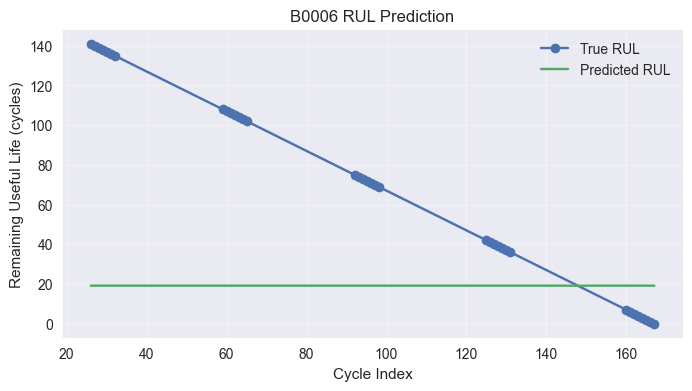

In [15]:
# 실제 RUL과 예측 RUL 비교 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(val_results["cycle_index"], val_results["rul_cycle"], label="True RUL", marker="o")
ax.plot(val_results["cycle_index"], val_results["pred_rul"], label="Predicted RUL", marker="x")
ax.set_xlabel("Cycle Index")
ax.set_ylabel("Remaining Useful Life (cycles)")
ax.set_title(f"{battery_id} RUL Prediction")
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()


## 다음 단계 아이디어

- 다른 배터리 ID에 대해 동일한 파이프라인을 적용해 정확도를 비교할 수 있습니다.
- 시퀀스 길이, 입력 특성 조합, 정규화 방식 등을 바꿔 민감도를 분석해 보세요.
- 하이퍼파라미터 최적화나 GRU, 1D-CNN과 같은 다른 시계열 모델과의 비교도 가치가 있습니다.
